##  Domain Adaptation with DANN on Toy Strong Lensing Images

In this extension of the tutorial, we will demonstrate how **Domain-Adversarial Neural Networks (DANN)** can be used to handle **domain shift** in a toy strong lensing setup. **Strong Gravitational Lensing** is a phenomenon where light from a distant galaxy is bent around a massive object (like another galaxy or a cluster), creating **ring-like patterns** called *Einstein rings*.

**Data Credit** [Machine Learning for Physics and Astronomy](https://github.com/LHCfitNikhef/ML4PA/blob/master/tutorials/2021-2022/tutorial6/tutorial6_CNN_inference.ipynb)

### Why DANN?

In real-world astrophysics, imaging conditions vary widely — different telescopes, exposure times, noise levels, or preprocessing pipelines introduce **domain differences**. For instance:
- Simulated data (source domain) is clean and ideal.
- Real telescope data (target domain) is noisy and complex.

Training a neural network only on the simulated (source) data often fails to generalize to real (target) images — this is known as **domain shift**.

### What is DANN doing?

DANN allows us to **learn domain-invariant features** from both domains, using:
1. A **feature extractor** shared by both tasks,
2. A **label predictor** trained only on the source domain (where we know the ring radius, width, and number),
3. A **domain classifier** that tries to distinguish whether a feature came from the source or target domain.

Using a **gradient reversal layer (GRL)**, we adversarially train the feature extractor to fool the domain classifier — pushing it to learn features that work well regardless of domain.

### In this notebook

We will:
- Use the simulated lensing image generator from the original tutorial.
- Simulate a **domain shift** by altering the image generation process (e.g., blur, noise, artifacts).
- Train a DANN to predict ring properties on the **source domain** while making the features generalize to the **target domain**.

This approach bridges the gap between simulation and real-world astrophysical inference, making models more robust and deployable on real telescope data.

![DANN](./DANN.png)

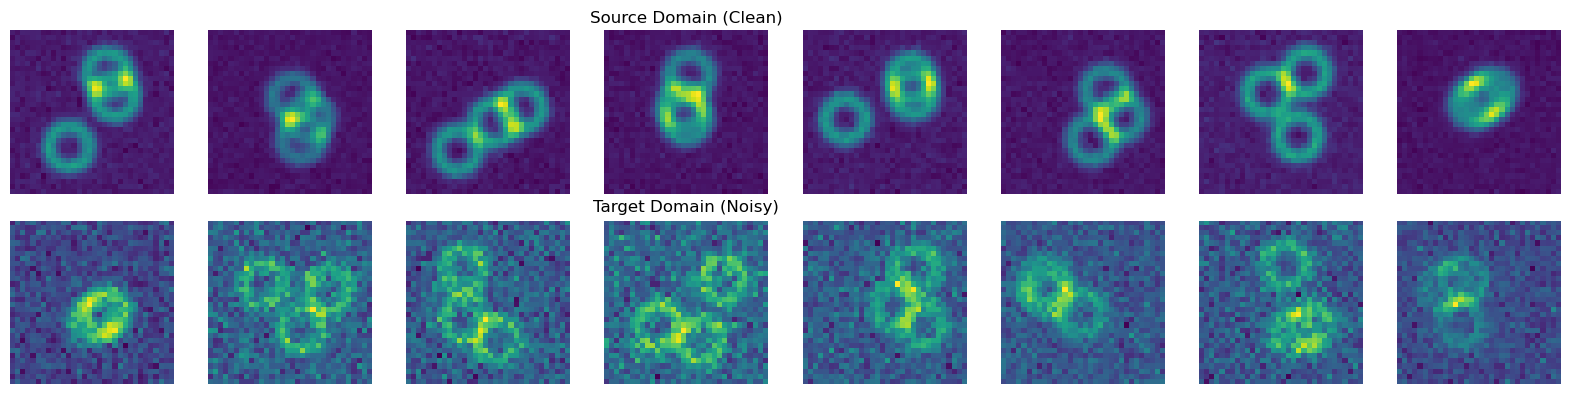

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Original image generation function
def image_model(radius=0.5, sigma=0.1, width=0.15, n=1):
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)
    imgs = []

    for i in range(n):
        x0, y0 = np.random.uniform(-1, 1, 2)
        R = np.sqrt((X - x0)**2 + (Y - y0)**2)
        img = np.exp(-((R - radius)**2) / (2 * width**2))
        imgs.append(img)

    img = sum(imgs)

    # Add Gaussian noise
    img += np.random.randn(*img.shape) * sigma

    # Normalize to zero mean and unit variance
    img -= img.mean()
    img /= img.std()
    return img

# Generate clean (source) and noisy (target) images
def generate_source_and_target_examples(n=8):
    source_imgs = [image_model(radius=0.5, sigma=0.05, width=0.15, n=3) for _ in range(n)]
    target_imgs = [image_model(radius=0.5, sigma=0.3, width=0.15, n=3) for _ in range(n)]
    return source_imgs, target_imgs

# Display them side-by-side
source_imgs, target_imgs = generate_source_and_target_examples(n=8)

plt.figure(figsize=(16, 4))

for i in range(8):
    # Source (clean)
    plt.subplot(2, 8, i + 1)
    plt.imshow(source_imgs[i], cmap='viridis')
    plt.axis('off')
    if i == 3:
        plt.title("Source Domain (Clean)", fontsize=12)

    # Target (noisy)
    plt.subplot(2, 8, i + 9)
    plt.imshow(target_imgs[i], cmap='viridis')
    plt.axis('off')
    if i == 3:
        plt.title("Target Domain (Noisy)", fontsize=12)

plt.tight_layout()
plt.show()


## Let's Create a simple Convolutional DANN

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# --- Image simulation ---
def simulate_ring_image(radius=0.5, sigma=0.1, width=0.15, n=1, noise=0.05):
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)
    
    if n == 0:
        img = np.zeros_like(X, dtype=np.float32)
    else:
        imgs = []
        for _ in range(n):
            x0, y0 = np.random.uniform(-1, 1, 2)
            R = np.sqrt((X - x0) ** 2 + (Y - y0) ** 2)
            img = np.exp(-((R - radius) ** 2) / (2 * width ** 2))
            imgs.append(img)
        img = sum(imgs)

    # Add Gaussian noise
    img += np.random.randn(*img.shape) * noise
    img -= img.mean()
    img /= img.std()
    return img.astype(np.float32)

# --- Dataset ---
class RingDataset(torch.utils.data.Dataset):
    def __init__(self, domain='source', num_samples=1000, include_noise=False):
        self.data = []
        self.labels = []

        for _ in range(num_samples):
            if include_noise and np.random.rand() < 0.3:
                # Create a pure noise image (label 0 = no ring)
                img = simulate_ring_image(n=0, noise=0.3 if domain == 'target' else 0.05)
                label = 0
            else:
                # Simulate 1–2 rings (label 1 = ring present)
                n_rings = np.random.choice([1, 2])
                img = simulate_ring_image(n=n_rings, noise=0.3 if domain == 'target' else 0.05)
                label = 1

            self.data.append(img)
            self.labels.append(label)

        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx][np.newaxis, ...]
        label = self.labels[idx]
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# --- DANN Modules ---
# --- Gradient Reversal Layer ---
class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

# --- DANN Model (CNN version)
class DANNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(DANNModel, self).__init__()

        # Feature extractor (Conv-based)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.LeakyReLU()
        )

        # Label classifier
        self.label_classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

        # Domain classifier
        self.domain_classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, alpha):
        features = self.feature_extractor(x)

        reverse_features = ReverseLayerF.apply(features, alpha)
        class_output = self.label_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output

In [16]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# --- Data loaders (include pure noise samples) ---
source_loader = DataLoader(RingDataset(domain='source', num_samples=10000, include_noise=True),
                           batch_size=64, shuffle=True)
target_loader = DataLoader(RingDataset(domain='target', num_samples=10000, include_noise=True),
                           batch_size=64, shuffle=True)
target_iter = iter(target_loader)

# --- Device and model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DANNModel(num_classes=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# --- Training loop ---
n_epochs = 10
len_dataloader = min(len(source_loader), len(target_loader))
lambda_d = 0.01

for epoch in range(n_epochs):
    model.train()
    total_cls_loss = 0.0
    total_dom_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for step, (source_x, source_y) in enumerate(source_loader):
        try:
            target_x, _ = next(target_iter)
        except StopIteration:
            target_iter = iter(target_loader)
            target_x, _ = next(target_iter)

        # Alpha schedule for domain adversarial
        p = float(epoch * len_dataloader + step) / (n_epochs * len_dataloader)
        alpha = 2. / (1. + torch.exp(torch.tensor(-10 * p))) - 1

        # Labels
        domain_src = torch.zeros(source_x.size(0), 1).to(device)
        domain_tgt = torch.ones(target_x.size(0), 1).to(device)
        domain_labels = torch.cat([domain_src, domain_tgt], dim=0)

        # Move data to device
        source_x, source_y = source_x.to(device), source_y.to(device)
        target_x = target_x.to(device)

        # Combine input
        x_all = torch.cat([source_x, target_x], dim=0)

        # Forward pass
        class_preds, domain_preds = model(x_all, alpha)

        # Label classification loss on source domain only
        class_loss = F.cross_entropy(class_preds[:source_x.size(0)], source_y)

        # Domain loss on both source and target
        domain_loss = F.binary_cross_entropy(domain_preds, domain_labels)

        # Total loss
        loss = class_loss + lambda_d * domain_loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_cls_loss += class_loss.item()
        total_dom_loss += domain_loss.item()

        # Classification accuracy on source
        predicted = class_preds[:source_x.size(0)].argmax(dim=1)
        correct_preds += (predicted == source_y).sum().item()
        total_preds += source_y.size(0)

    acc = correct_preds / total_preds
    print(f"[Epoch {epoch+1}/{n_epochs}]  "
          f"Label Loss: {total_cls_loss:.4f}  "
          f"Domain Loss: {total_dom_loss:.4f}  "
          f"Source Acc: {acc * 100:.2f}%")

[Epoch 1/10]  Label Loss: 50.8106  Domain Loss: 49.3024  Source Acc: 99.21%
[Epoch 2/10]  Label Loss: 49.4804  Domain Loss: 113.6011  Source Acc: 99.80%
[Epoch 3/10]  Label Loss: 49.2588  Domain Loss: 121.3501  Source Acc: 99.95%
[Epoch 4/10]  Label Loss: 49.2042  Domain Loss: 98.4200  Source Acc: 99.99%
[Epoch 5/10]  Label Loss: 49.2047  Domain Loss: 101.7467  Source Acc: 99.98%
[Epoch 6/10]  Label Loss: 49.1971  Domain Loss: 98.0648  Source Acc: 100.00%
[Epoch 7/10]  Label Loss: 49.2157  Domain Loss: 99.2427  Source Acc: 99.98%
[Epoch 8/10]  Label Loss: 49.1821  Domain Loss: 97.9322  Source Acc: 100.00%
[Epoch 9/10]  Label Loss: 49.2793  Domain Loss: 96.2174  Source Acc: 99.94%
[Epoch 10/10]  Label Loss: 49.3470  Domain Loss: 93.8112  Source Acc: 99.90%


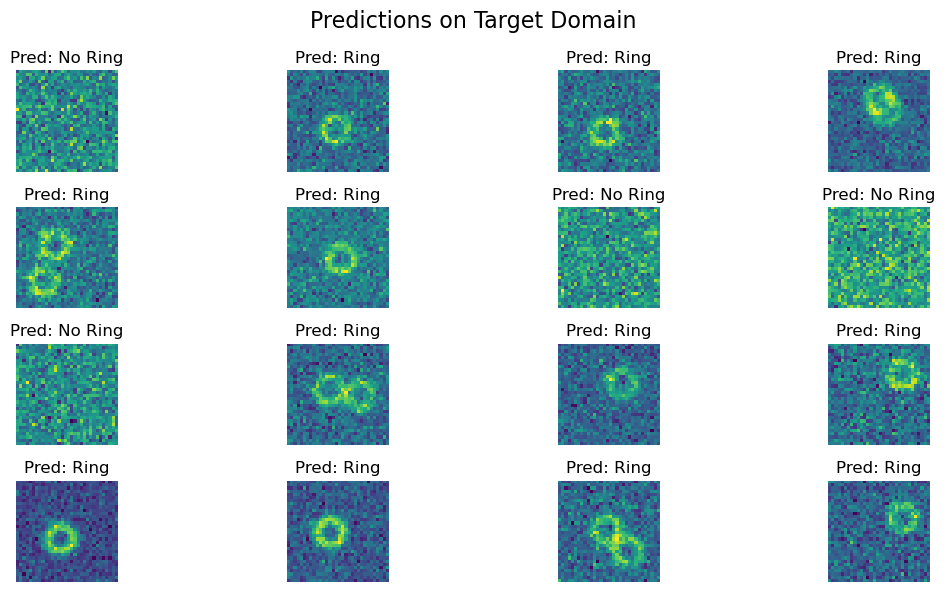

In [17]:
import matplotlib.pyplot as plt

def visualize_target_predictions(model, device, n_samples=16):
    # Load some target samples
    dataset = RingDataset(domain='target', num_samples=n_samples, include_noise=True)
    model.eval()

    plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for i in range(n_samples):
            x, _ = dataset[i]
            x_input = x.unsqueeze(0).to(device)  # Add batch dim
            class_probs, _ = model(x_input, alpha=0.0)
            pred_class = torch.argmax(class_probs, dim=1).item()

            label_str = "Ring" if pred_class == 1 else "No Ring"

            plt.subplot(4, 4, i+1)
            plt.imshow(x[0].cpu(), cmap='viridis')
            plt.title(f"Pred: {label_str}")
            plt.axis('off')

    plt.suptitle("Predictions on Target Domain", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Usage ---
visualize_target_predictions(model, device)

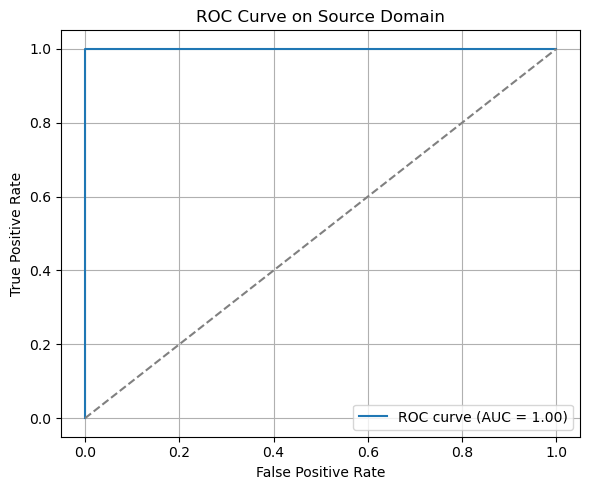

Source Domain AUC: 1.0000


In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# --- Evaluation function ---
def evaluate_roc_on_source(model, dataloader, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.numpy()
            
            # Forward
            class_probs, _ = model(x_batch, alpha=0.0)
            probs_ring = class_probs[:, 1].cpu().numpy()  # class 1 = ring

            y_true.extend(y_batch)
            y_scores.extend(probs_ring)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    # --- Plot ---
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Source Domain")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return auc

# --- Usage ---
source_eval_loader = DataLoader(RingDataset(domain='source', num_samples=1000, include_noise=True),
                                batch_size=64, shuffle=False)

auc_score = evaluate_roc_on_source(model, source_eval_loader, device)
print(f"Source Domain AUC: {auc_score:.4f}")